<!-- Department Logo + Title Block -->

<div style="display: flex; align-items: center; justify-content: space-between; padding: 15px; border-bottom: 3px solid #003366;">

  <!-- Logo -->
  <div style="flex: 0 0 auto;">
    <img src="../../dcs_logo_small.png" alt="Department Logo" style="height:150px;">
  </div>

  <!-- Title -->
  <div style="text-align: center; flex-grow: 0; flex-shrink: 1; margin: 0 auto;">
    <h1 style="margin: 0; font-size: 26px; color: #003366;">Deep Reinforcement Learning (CS-866)</h1>
    <h2 style="margin: 0px 0; font-size: 20px; color: #005599;">Department of Computer Science</h2>
    <h2 style="margin: 0px 0; font-size: 20px; color: #005599;">University of the Punjab</h2>
    <br><br>
    <h3 style="margin: 0px 0; font-size: 20px; color: #222;"><b>CartPole with REINFORCE (Policy Gradient)</b></h3>
    <h4 style="margin: 0px 0; font-size: 16px; color: #444;"><b>Instructor: <b>Nazar Khan</b></h4>    
  </div>

  <!-- Right Logo -->
  <!--<div style="flex: 0 0 auto;">
    <img src="pu_logo.png" alt="University Logo" style="height:180px;">
  </div>-->

  <!-- Empty Spacer (optional for symmetry) -->
  <div style="flex: 0 0 auto; width: 80px;"></div>
</div>

#### Goal
- We will train a neural network that outputs probabilities of actions that can be applied to a cart to balance a pole attached to it.
- The network becomes more likely to repeat actions that led to good outcomes.

#### Imports

In [2]:
# We import Gymnasium to create RL environments like CartPole
import gymnasium as gym

# Torch is the PyTorch library for building and training neural networks
import torch

# nn gives us building blocks for neural networks (layers, activations, etc.)
import torch.nn as nn

# optim gives us optimization algorithms like Adam to adjust network weights
import torch.optim as optim

# numpy is a numerical library (we'll use it a tiny bit)
import numpy as np

#### Define the Neural Network that will represent the policy

In [3]:
class PolicyNetwork(nn.Module):  
    # This class defines our neural network (our policy function π(a|s; θ))
    # It takes in the state and outputs probabilities for each action.

    def __init__(self, state_dim, action_dim):
        # state_dim = number of numbers that describe the state (CartPole has 4)
        # action_dim = number of possible actions (CartPole has 2: left or right)
        super().__init__()

        # nn.Sequential lets us stack layers in order, like a list
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),  # first layer: input vector mapped to 128 neurons
            nn.ReLU(),                  # activation function: adds non-linearity
            nn.Linear(128, action_dim), # second layer: 128 neurons mapped to number of actions
            nn.Softmax(dim=-1)          # convert numbers into probabilities
        )

    def forward(self, x):
        # forward defines how input flows through the network
        return self.net(x)

#### Implementation of the REINFORCE algorithm for learning neural network parameters of optimal policy

In [4]:
def reinforce(env_name='CartPole-v1', gamma=0.99, lr=1e-3, episodes=500):

    # Create the environment
    env = gym.make(env_name)

    # Get size of state and action spaces from environment
    state_dim = env.observation_space.shape[0]  # e.g., 4 for CartPole
    action_dim = env.action_space.n             # e.g., 2 actions

    # Create the neural network policy
    policy = PolicyNetwork(state_dim, action_dim)

    # Adam optimizer will adjust neural network weights based on gradients
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    # Keep track of total reward each episode to see learning progress
    returns_history = []

    # Loop over episodes of training
    for episode in range(episodes):

        # Reset environment at start of episode and get initial state
        state, _ = env.reset()

        # Lists to store log-probabilities and rewards for this episode
        log_probs = []  
        rewards = []    

        done = False  # episode is not finished yet

        # Generate an episode
        while not done:
            
            # Convert state list/array to PyTorch tensor (NEEDED for network input)
            state_tensor = torch.tensor(state, dtype=torch.float32)

            # Forward pass: get action probabilities from policy network
            action_probs = policy(state_tensor)

            # Turn probabilities into a "distribution" (randomness)
            dist = torch.distributions.Categorical(action_probs)

            # Sample an action according to probabilities
            action = dist.sample()

            # Save log(probability(action_taken)) for learning update later
            log_probs.append(dist.log_prob(action))

            # Take action in environment and observe next state and reward
            state, reward, done, truncated, _ = env.step(action.item())

            # Save reward to compute return G later
            rewards.append(reward)

        # Episode finished. Now compute returns (discounted reward sums)

        returns = []
        G = 0  # return accumulator

        # Compute returns G_t for each time step t, working backwards
        for r in reversed(rewards):
            G = r + gamma * G  # Bellman return formula
            returns.insert(0, G)

        # Convert to PyTorch tensor so gradients flow properly
        returns = torch.tensor(returns, dtype=torch.float32)

        # Normalize returns. This helps stable training (optional but recommended)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Compute loss = −Σ log(pi(action|state)) * G_t
        # (negative because we want gradient ASCENT, but optimizer does DESCENT)
        loss = 0
        for log_p, Gt in zip(log_probs, returns):
            loss += -log_p * Gt

        # Backpropagation step
        optimizer.zero_grad()  # clear old gradients
        loss.backward()        # compute gradients
        optimizer.step()       # update neural network weights

        # Store total reward for this episode for plotting later
        returns_history.append(sum(rewards))

        # Print progress occasionally
        if episode % 20 == 0:
            print(f"Episode {episode:4d} | Return = {sum(rewards):.2f}")

    env.close()
    return policy, returns_history


#### Train the policy network

In [5]:
policy, history = reinforce()

Episode    0 | Return = 8.00
Episode   20 | Return = 12.00
Episode   40 | Return = 17.00
Episode   60 | Return = 51.00
Episode   80 | Return = 28.00
Episode  100 | Return = 29.00
Episode  120 | Return = 40.00
Episode  140 | Return = 66.00
Episode  160 | Return = 53.00
Episode  180 | Return = 87.00
Episode  200 | Return = 32.00
Episode  220 | Return = 152.00
Episode  240 | Return = 118.00
Episode  260 | Return = 85.00
Episode  280 | Return = 87.00
Episode  300 | Return = 262.00
Episode  320 | Return = 133.00
Episode  340 | Return = 341.00
Episode  360 | Return = 448.00
Episode  380 | Return = 193.00
Episode  400 | Return = 340.00
Episode  420 | Return = 346.00
Episode  440 | Return = 496.00
Episode  460 | Return = 183.00
Episode  480 | Return = 516.00


#### Plot the learning curve

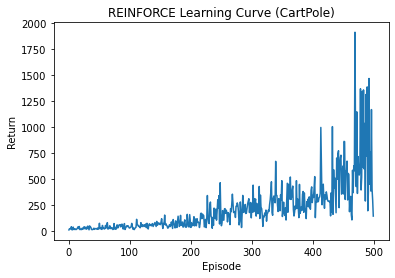

In [6]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("REINFORCE Learning Curve (CartPole)")
plt.show()


#### Run 5 episodes either until failure or until 500 steps (whichever comes earlier)

In [7]:
import imageio
import cv2
from IPython.display import Image

def record_episodes(num_episodes=5, filename="episodes.gif"):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    frames = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        
        done = False
        step = 0
        
        while not done:
            step += 1
            
            # Convert state to tensor
            state_t = torch.tensor(state, dtype=torch.float32)
            probs = policy(state_t)
            action = torch.argmax(probs).item()
        
            # Act
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Get frame
            frame = env.render()
    
            ## frame is in RGB format but OpenCV expects it in BGR format
            #frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
            # Draw step number on frame
            frame = cv2.putText(
                frame, 
                f"Episode: {episode+1}, Step: {step}", 
                (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255, 0, 0), 2
            )
        
            #cv2.imshow("CartPole", frame)
            #cv2.waitKey(5)  # Adjust speed (ms)
            frames.append(frame)
    
    env.close()
    imageio.mimsave(filename, frames, fps=100)
    print(f"Saved {filename}")
    #cv2.destroyAllWindows()

filename = "REINFORCE_cartpole_episodes.gif"
record_episodes(num_episodes=5, filename=filename)

Saved REINFORCE_cartpole_episodes.gif


In [15]:
#Image(filename)

<div style="flex: 0 0 auto;">
    <img src="REINFORCE_cartpole_episodes.gif" alt="REINFORCE_cartpole_episodes" style="height:250px; loop">
</div>

#### GIFs

In [9]:
import imageio
import cv2

def record_trained_gif(policy, filename="trained_cartpole.gif", max_steps=500):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    state, _ = env.reset()

    frames = []
    step = 0
    done = False

    while not done and step < max_steps:
        step += 1

        # Select greedy action from policy
        state_t = torch.tensor(state, dtype=torch.float32)
        probs = policy(state_t)
        action = torch.argmax(probs).item()

        state, r, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        frame = env.render()
        frame = cv2.putText(frame.copy(),
                            f"Step {step}", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        frames.append(frame)

    env.close()
    imageio.mimsave(filename, frames, fps=30)
    print(f"Saved {filename}")


record_trained_gif(policy)


Saved trained_cartpole.gif


<img src="trained_cartpole.gif" alt="trained_cartpole" loop>

#### Random vs Trained Policy

In [14]:
from PIL import Image

def combine_frames(f1, f2):
    return np.hstack([f1, f2])

def record_side_by_side(policy, filename="comparison.gif", max_steps=500):
    env1 = gym.make("CartPole-v1", render_mode="rgb_array")  # random
    env2 = gym.make("CartPole-v1", render_mode="rgb_array")  # trained

    s1, _ = env1.reset()
    s2, _ = env2.reset()

    frames = []
    for step in range(max_steps):

        # --- Random Agent ---
        a1 = env1.action_space.sample()
        s1, _, d1, t1, _ = env1.step(a1)
        frame_random = env1.render()
        cv2.putText(frame_random, "Random", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        # --- Trained Agent ---
        probs = policy(torch.tensor(s2, dtype=torch.float32))
        a2 = torch.argmax(probs).item()
        s2, _, d2, t2, _ = env2.step(a2)
        frame_rl = env2.render()
        cv2.putText(frame_rl, "Trained", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

        frame = combine_frames(frame_random, frame_rl)
        frames.append(frame)

        if d1 or t1 or d2 or t2:
            break

    env1.close(); env2.close()
    imageio.mimsave(filename, frames, fps=5)
    print(f"Saved {filename}")

record_side_by_side(policy)


Saved comparison.gif


<img src="comparison.gif" alt="trained_cartpole" loop>

#### Live Policy Probability Plot

Shows how policy output evolves during one run (probs for LEFT vs RIGHT at every step)

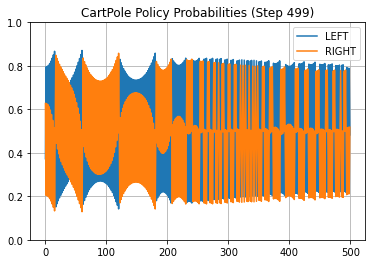

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def run_with_live_probs(policy, episodes=1, max_steps=500):
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    for ep in range(episodes):
        state,_ = env.reset()
        probs_list = []

        for step in range(max_steps):
            state_t = torch.tensor(state, dtype=torch.float32)
            probs = policy(state_t).detach().numpy()
            probs_list.append(probs)

            action = np.argmax(probs)
            state, _, terminated, truncated, _ = env.step(action)

            # live plot
            clear_output(wait=True)
            plt.figure(figsize=(6,4))
            arr = np.array(probs_list)
            plt.plot(arr[:,0], label="LEFT")
            plt.plot(arr[:,1], label="RIGHT")
            plt.ylim(0,1)
            plt.title(f"CartPole Policy Probabilities (Step {step})")
            plt.legend()
            plt.grid()
            display(plt.gcf())
            plt.close()

            if terminated or truncated:
                break

    env.close()

run_with_live_probs(policy)
